# Training and Making predicting

## Description

**8 Models considered:**

For Penelized linear models: Lasso, Ridge, Elastic Net regression 

For Linear dimension reduction tech: PCR, partial least squares regressions 

For Nonlinear models: RF, gradient boosted tree regression (GBR), gradient boosted tree regression with dropout (Dart), deep feed=forward neural networks (FFN)

**Assessing predictive power:**

standard out-of-sample $R^2$ statistic

$$
R^2_{OS} = 1 - \frac{\sum_{(i,t)\in T_3} (r_{i, s, t+1} 
            - \hat{r}_{i,s,t+1})^2} {\sum_{(i,t)\in T_3 r^2_{i, s,t+1}}}
$$

**Four Periods:**

$T_1$ (1996/01 -- 2000/12) -> training

$T_2$ (2001 -- 2002) -> *hyperparameter* optimization **validating**

$T_3$ (2003) -> **testing**

> We repeat this procedure for each year in the testing sample from 2003 through 2020, increasing the number of training years by one at each iteration.

That is: 
* First iteration: 1996 ~ 2000 as train, 2001 ~ 2002 as validate, 2003 as test 

* Second iteration: 1996 ~ 2001 as train, 2002 ~ 2003 as validate, 2004 as test 

... 

* i-th iteration: 1996 ~ 2000 + i-1 as train, 2000 + i ~ 2000 + i+1 as validation, 2000 + i+2 as test

***QUESTION*** How the reported $R^2$ or $R^2_{OS,XS}$ is estimated, since we are running training-validation-testing procedure on multiple periods? 

**Cross sectional asset pricing test**

> In cross-sectional asset pricing tests, our main objective is not to forecast time-series variation in future returns, but rather cross-sectional return spreads in the testing sample.

Han et al (2021) proposes a cross-sectional out-of-sample $R^2$:

$$
R^2_{OS; XS} = 1 - \frac{\sum_{(i,t)\in T_3} [(r_{i,s,t+1} - \bar{r}_{i,s,t+1}) - (\hat{r}_{i,s,t+1} - \bar{\hat{r}}_{i,s,t+1})]^2} 
{\sum_{(i,t)\in T_3} (r_{i,s,t+1} - \bar{r}_{i,s,t+1})^2}
$$

> $R^2_{OS; XS}$ focuses on relative expected returns across options, for which accurate predictions result in profitable long-short trading strategies.

**Statistical significance of models forecasts**

**1. CW test (for individual model)**

$$
CW^{(j)} = \frac{\bar{c}^{(j)}}  {\hat{\sigma}_c^{(j)}}
$$

where $\bar{c}^{(j)}$ is the time series average, and $\hat{\sigma}_c^{(j)}$ is the Newey and West 
standard error ***of*** the mean difference squared forecast errors: 

$$
c_{t+1}^{(j)} = \frac{1}{n_{T_3}} \sum_{(i,t)\in T_3} [r_{i,s,t+1}^2 - (\hat{e}_{i,t+1}^{(j)})^2]
$$

where $n_{T_3}$ is the number of observations in the testing sample and $\hat{e}_{i,t+1}$ is the 
forecast error on option i at time t+1 for method j. 

**2. DM test (for comparison)**

Diebold and Mariano (1995) (DM) test

The DM test-statisics for a comparison between methods 1 and 2 is defined as: 

$$
DM^{(1,2)} = \frac{\bar{d}^{(1,2)}} {\hat{\sigma}_d^{(1,2)}}
$$

where $\bar{d}^{(1,2)}$ is the time series average, and $\hat{\sigma}_d^{(1,2)}$ is the Newey and West 
standard error ***of*** the mean difference squared forecast errors: 

$$
d^{(1,2)}_{t+1} = \frac{1}{n_{T_3}} \sum_{(i,t)\in T_3} [(\hat{e}^{(1)}_{i, t+1})^2 - (\hat{e}^{(2)}_{i, t+1})^2]
$$


In [1]:
import numpy as np
import datetime as dt

from evaluation_metrics import CW_test, DM_test, R_squared_OSXS

import pandas as pd 
import os


In [2]:
import numpy as np
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])

X = [[np.nan, 2], [6, np.nan], [7, 6]]

imp.transform(X)

array([[4.        , 2.        ],
       [6.        , 3.66666667],
       [7.        , 6.        ]])

## Import data

In [3]:
DATAROOT = "data/"

In [4]:
option_with_feature = pd.read_csv(os.path.join(DATAROOT, "all_characteristics.csv"))

In [5]:
sp500_op_ret = pd.read_csv(os.path.join(DATAROOT, "sp500_op_ret.csv"))

In [6]:
option_with_feature["date"] = pd.to_datetime(option_with_feature["date"])

In [7]:
sp500_op_ret["date"] = pd.to_datetime(sp500_op_ret["date"])

In [8]:
option_with_feature = option_with_feature.merge(sp500_op_ret, on=["date", "optionid"], how="inner")

In [123]:
# sparsity of data
sparsity_dict = dict(option_with_feature.isna().sum())
df = pd.DataFrame({
    "col_name": list(sparsity_dict.keys()),
    "perc_of_na": list(i / option_with_feature.shape[0] for i in sparsity_dict.values())
})
    

In [125]:
df.describe()

,perc_of_na
count,277.000000
mean,0.203115
std,0.300341
min,0.000000
25%,0.000506
50%,0.051889
75%,0.230961
max,0.999997


['skewiv',
 'atm_civpiv',
 'atm_dcivpiv',
 'ivslope',
 'AccrualsBM',
 'Activism1',
 'Activism2',
 'AdExp',
 'AgeIPO',
 'AnalystValue',
 'AOP',
 'BrandInvest',
 'ChangeInRecommendation',
 'ChForecastAccrual',
 'ChNAnalyst',
 'CitationsRD',
 'ConsRecomm',
 'CredRatDG',
 'CustomerMomentum',
 'DelDRC',
 'DivSeason',
 'DivYieldST',
 'DownRecomm',
 'EarningsConsistency',
 'EarningsForecastDisparity',
 'EarnSupBig',
 'FirmAge',
 'FirmAgeMom',
 'ForecastDispersion',
 'FR',
 'Frontier',
 'Governance',
 'GrAdExp',
 'IndRetBig',
 'InvGrowth',
 'IO_ShortInterest',
 'iomom_cust',
 'iomom_supp',
 'Mom6mJunk',
 'MomOffSeason16YrPlus',
 'MomRev',
 'MomSeason16YrPlus',
 'MS',
 'NetDebtPrice',
 'OperProfRD',
 'OrderBacklog',
 'OrderBacklogChg',
 'OrgCap',
 'OScore',
 'PatentsRD',
 'PayoutYield',
 'PredictedFE',
 'ProbInformedTrading',
 'PS',
 'RD',
 'RDAbility',
 'RDcap',
 'realestate',
 'retConglomerate',
 'REV6',
 'RIO_Disp',
 'RIO_MB',
 'RIO_Turnover',
 'RIO_Volatility',
 'sfe',
 'ShareVol',
 'sinAlg

In [129]:
# we aim to handle sparsity: delete columns with sparsity more than 0.24, 
# so we we preserve 75% of the features

In [9]:
"gamma" in option_with_feature.columns

False

In [132]:
",".join(f"'{i}'" for i in sorted(list(
    set(
    option_with_feature._get_numeric_data().columns.difference([
    'Unnamed: 0',
    'secid',
    'permno',
    'optionid',
    "option_ret",
        "yyyymm",
# due to computing error, they used future info
        "ailliq",
        "pilliq"
])
    ) - set(df[df.perc_of_na > 0.23].col_name)
)))

"'AM','AbnormalAccruals','Accruals','AnalystRevision','AnnouncementReturn','AssetGrowth','BM','BMdec','BPEBM','Beta','BetaFP','BetaLiquidityPS','BetaTailRisk','BidAskSpread','BookLeverage','C','CBOperProf','CF','Cash','CashProd','ChAssetTurnover','ChEQ','ChInv','ChInvIA','ChNNCOA','ChNWC','ChTax','CompEquIss','CompositeDebtIssuance','ConvDebt','CoskewACX','Coskewness','DebtIssuance','DelBreadth','DelCOA','DelCOL','DelEqu','DelFINL','DelLTI','DelNetFin','DivInit','DivOmit','DolVol','EBM','EP','EarningsStreak','EarningsSurprise','EntMult','EquityDuration','ExchSwitch','ExclExp','FEPS','GP','GrLTNOA','GrSaleToGrInv','GrSaleToGrOverhead','Herf','HerfAsset','HerfBE','High52','IdioRisk','IdioVol3F','IdioVolAHT','Illiquidity','IndIPO','IndMom','IntMom','IntanBM','IntanCFP','IntanEP','IntanSP','InvestPPEInv','Investment','LRreversal','Leverage','MRreversal','MaxRet','MeanRankRevGrowth','Mom12m','Mom12mOffSeason','Mom6m','MomOffSeason','MomOffSeason06YrPlus','MomOffSeason11YrPlus','MomSeason','

In [10]:
# used characteristics
_ = [print(f"'{i}'", end=", ") for i in sorted(list(option_with_feature.columns.difference(['Unnamed: 0',
 'secid',
 'permno',
 'date',
 'exdate',
 'optionid',
 'bucket_class', "yyyymm", "option_ret"])))
]

'AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP', 'BetaLiquidityPS', 'BetaTailRisk', 'BidAskSpread', 'BookLeverage', 'BrandInvest', 'C', 'CBOperProf', 'CF', 'Cash', 'CashProd', 'ChAssetTurnover', 'ChEQ', 'ChForecastAccrual', 'ChInv', 'ChInvIA', 'ChNAnalyst', 'ChNNCOA', 'ChNWC', 'ChTax', 'ChangeInRecommendation', 'CitationsRD', 'CompEquIss', 'CompositeDebtIssuance', 'ConsRecomm', 'ConvDebt', 'CoskewACX', 'Coskewness', 'CredRatDG', 'CustomerMomentum', 'DebtIssuance', 'DelBreadth', 'DelCOA', 'DelCOL', 'DelDRC', 'DelEqu', 'DelFINL', 'DelLTI', 'DelNetFin', 'DivInit', 'DivOmit', 'DivSeason', 'DivYieldST', 'DolVol', 'DownRecomm', 'EBM', 'EP', 'EarnSupBig', 'EarningsConsistency', 'EarningsForecastDisparity', 'EarningsStreak', 'EarningsSurprise', 'EntMult', 'EquityDuration', 'ExchSwitch', 'ExclExp', 'FEPS', 'FR', 'FirmAge', 'Firm

,Unnamed: 0,secid,permno,date,exdate,optionid,bucket_class,C,P,expiration_month,...,TotalAccruals,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,zerotrade,zerotradeAlt1,zerotradeAlt12
0,0,5015,56266.0,1996-01-31,1996-07-20,10980421,"ITM,L",1,0,0,...,NaN,1.0,-0.002398,-0.083688,-3.469586,-0.010613,NaN,2.212753e-08,2.905242e-08,3.159365e-08
1,1,5015,56266.0,1996-01-31,1996-07-20,10385280,"ATM,L",1,0,0,...,NaN,1.0,-0.002398,-0.083688,-3.469586,-0.010613,NaN,2.212753e-08,2.905242e-08,3.159365e-08
2,2,5015,56266.0,1996-01-31,1996-07-20,10440757,"OTM,L",1,0,0,...,NaN,1.0,-0.002398,-0.083688,-3.469586,-0.010613,NaN,2.212753e-08,2.905242e-08,3.159365e-08
3,3,5015,56266.0,1996-01-31,1996-04-20,10752997,"ATM,S",0,1,0,...,NaN,1.0,-0.002398,-0.083688,-3.469586,-0.010613,NaN,2.212753e-08,2.905242e-08,3.159365e-08
4,4,5015,56266.0,1996-01-31,1996-04-20,11214327,"ATM,S",0,1,0,...,NaN,1.0,-0.002398,-0.083688,-3.469586,-0.010613,NaN,2.212753e-08,2.905242e-08,3.159365e-08


In [11]:
# option_with_feature = pd.read_csv(os.path.join(DATAROOT, "option_with_nonsparse_features.csv"))

In [11]:
option_with_feature.shape

(3430490, 277)

In [12]:
option_with_feature = option_with_feature[~option_with_feature.option_ret.isna()]

In [13]:
option_with_feature.shape

(3430352, 277)

In [13]:
total_row_num = option_with_feature.shape[0]
# option_with_feature = option_with_feature.dropna()
# print(f"number of na rows: {total_row_num - option_with_feature.shape[0]}")

In [14]:
total_row_num

3981898

In [32]:
any(option_with_feature.columns.duplicated())

False

In [212]:
option_with_feature = option_with_feature.loc[:,~option_with_feature.columns.duplicated()]

In [15]:
option_with_feature["date_x"] = option_with_feature.date_x.apply(lambda x: dt.datetime.strptime(x.split()[0], "%Y-%m-%d")).copy()

In [16]:
option_with_feature["cp_flag_encoded"] = option_with_feature["cp_flag"].apply(lambda x: {"P": 0, "C": 1}[x])

In [214]:
option_with_feature.sample(3)

,Unnamed: 0,secid_x,permno,date_x,exdate_x,optionid,bucket_class,C,P,expiration_month,...,theta_y,cfadj,days_no_trading,days_to_exp,forwardprice,spotprice,adj_spot,ir_rate,mid_price,option_ret
3231174,3231174,101121,61241.0,2020-07-31,2020-10-16,135275169,"OTM,S",1,0,0,...,-3.971454,1,0,77,77.463405,77.43,77.43,0.002045,0.265,-0.026853
2604334,2604334,102822,11552.0,2018-04-30,2019-01-18,117853059,"OTM,L",0,1,0,...,-1.180726,1,0,263,88.658018,87.10,87.10,0.024606,0.335,-0.032197
2523068,2523068,109181,10138.0,2017-12-29,2018-02-16,118468961,"ATM,S",0,1,0,...,-10.564550,1,0,49,105.158644,104.93,104.93,0.016214,2.975,0.011691


In [18]:
year = 1996
begin_date = dt.datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime(f"{year+4}-12-31", "%Y-%m-%d")
training_data = option_with_feature[
    option_with_feature.date_x.between(begin_date, end_date)
]


In [220]:
option_with_feature.date_x = pd.to_datetime(option_with_feature.date_x)

In [14]:
def train_validation_test_split(option_with_feature, year):
    begin_date = dt.datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+4}-12-31", "%Y-%m-%d")
    training_data = option_with_feature[
        option_with_feature.date.between(begin_date, end_date)
    ]

    begin_date = dt.datetime.strptime(f"{year+5}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+6}-12-31", "%Y-%m-%d")
    validation_data = option_with_feature[
        option_with_feature.date.between(begin_date, end_date)
    ]

    begin_date = dt.datetime.strptime(f"{year+7}-01-01", "%Y-%m-%d")
    end_date = dt.datetime.strptime(f"{year+7}-12-31", "%Y-%m-%d")
    test_data = option_with_feature[
        option_with_feature.date.between(begin_date, end_date)
    ]
    
    return training_data, validation_data, test_data

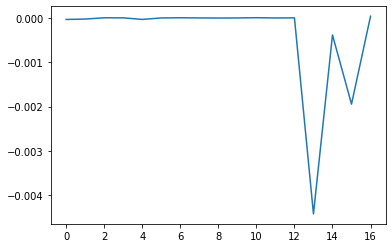

In [16]:
training_data, validation_data, test_data = train_validation_test_split(option_with_feature, 1996)

In [17]:
training_data.shape[0], validation_data.shape[0], test_data.shape[0]

(321491, 145707, 72746)

In [62]:
len(test_data.optionid), len(set(test_data.optionid))

(77333, 39123)

In [41]:
non_useable_feature = set()
for df in [training_data, validation_data, test_data]:
    for key, val in dict(df.isna().sum()).items():
        if val == df.shape[0]:
            print(key)
            non_useable_feature.add(key)

ChNAnalyst
RDcap
ChNAnalyst
RDcap
ChNAnalyst
ProbInformedTrading
RDcap


In [65]:
?SimpleImputer

Init signature:
SimpleImputer(
    *,
    missing_values=nan,
    strategy='mean',
    fill_value=None,
    verbose=0,
    copy=True,
    add_indicator=False,
)
Docstring:     
Imputation transformer for completing missing values.

Read more in the :ref:`User Guide <impute>`.

.. versionadded:: 0.20
   `SimpleImputer` replaces the previous `sklearn.preprocessing.Imputer`
   estimator which is now removed.

Parameters
----------
missing_values : int, float, str, np.nan or None, default=np.nan
    The placeholder for the missing values. All occurrences of
    `missing_values` will be imputed. For pandas' dataframes with
    nullable integer dtypes with missing values, `missing_values`
    should be set to `np.nan`, since `pd.NA` will be converted to `np.nan`.

strategy : str, default='mean'
    The imputation strategy.

    - If "mean", then replace missing values using the mean along
      each column. Can only be used with numeric data.
    - If "median", then replace missing values us

In [134]:
used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol']
used_characteristics = ['AM','AbnormalAccruals','Accruals','AnalystRevision','AnnouncementReturn','AssetGrowth','BM','BMdec','BPEBM','Beta','BetaFP','BetaLiquidityPS','BetaTailRisk','BidAskSpread','BookLeverage','C','CBOperProf','CF','Cash','CashProd','ChAssetTurnover','ChEQ','ChInv','ChInvIA','ChNNCOA','ChNWC','ChTax','CompEquIss','CompositeDebtIssuance','ConvDebt','CoskewACX','Coskewness','DebtIssuance','DelBreadth','DelCOA','DelCOL','DelEqu','DelFINL','DelLTI','DelNetFin','DivInit','DivOmit','DolVol','EBM','EP','EarningsStreak','EarningsSurprise','EntMult','EquityDuration','ExchSwitch','ExclExp','FEPS','GP','GrLTNOA','GrSaleToGrInv','GrSaleToGrOverhead','Herf','HerfAsset','HerfBE','High52','IdioRisk','IdioVol3F','IdioVolAHT','Illiquidity','IndIPO','IndMom','IntMom','IntanBM','IntanCFP','IntanEP','IntanSP','InvestPPEInv','Investment','LRreversal','Leverage','MRreversal','MaxRet','MeanRankRevGrowth','Mom12m','Mom12mOffSeason','Mom6m','MomOffSeason','MomOffSeason06YrPlus','MomOffSeason11YrPlus','MomSeason','MomSeason06YrPlus','MomSeason11YrPlus','MomSeasonShort','MomVol','NOA','NetDebtFinance','NetEquityFinance','NetPayoutYield','NumEarnIncrease','OPLeverage','OperProf','OptionVolume1','OptionVolume2','P','PctAcc','PctTotAcc','PriceDelayRsq','PriceDelaySlope','PriceDelayTstat','RDIPO','RDS','ResidualMomentum','ReturnSkew','ReturnSkew3F','RevenueSurprise','RoE','SP','ShareIss1Y','ShareIss5Y','ShareRepurchase','ShortInterest','SmileSlope','Spinoff','Tax','TotalAccruals','VarCF','VolMkt','VolSD','VolumeTrend','XFIN','adj_spot','best_bid','best_offer','betaVIX','bucket_dvol','bucket_vol','bucket_vol_share','cfadj','cfp','dNoa','days_no_trading','days_to_exp','dciv','delta_x','delta_y','doi','dpiv','dso','dvol','embedlev','expiration_month','fgr5yrLag','forwardprice','gamma_x','gamma_y','grcapx','grcapx3y','hire','impl_volatility','ir_rate','iv','ivd','ldso','lso','mid','mid_price','moneyness','nopt','ntm_civpiv','oi','oistock','open_interest','optspread','pba','pcpv','pcratio','roaq','secid_x','secid_y','shrtfee','skew1','so','spotprice','strike_price','theta_x','theta_y','toi','ttm','turnover','vega_x','vega_y','vol','volga','volume','vs_change','vs_level','zerotrade','zerotradeAlt1','zerotradeAlt12']
used_characteristics = list(set(used_characteristics) - set(non_useable_feature))

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(training_data[used_characteristics])

SimpleImputer()

In [135]:
len(used_characteristics)

194

In [136]:
imp.transform(training_data[used_characteristics]).shape, training_data[used_characteristics].shape

((321491, 194), (321491, 194))

In [137]:
training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

X_train = training_data[used_characteristics + ["date", "optionid"] ]
y_train = training_data['option_ret']

X_test = test_data[used_characteristics + ["date", "optionid"]]
y_test = test_data['option_ret']


# X_train.loc[:, used_characteristics] = imp.transform(X_train[used_characteristics])
# X_test.loc[:, used_characteristics]  = imp.transform(X_test[used_characteristics])

# for char in ["date_x", "optionid"]:
    # X_train[char] = training_data[char]
    # X_test[char]  = test_data[char]

/var/folders/nh/s3ft86ks12xd4qdptmv1pvtc0000gn/T/ipykernel_18198/1344904601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
/var/folders/nh/s3ft86ks12xd4qdptmv1pvtc0000gn/T/ipykernel_18198/1344904601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])


In [138]:
training_data["optionid"].shape, training_data["optionid"].dropna().shape
# training_data["date_x"].shape, training_data["date_x"].dropna().shape

((321491,), (321491,))

In [168]:
X_train.shape, X_train["optionid"].dropna().shape, (~X_train["optionid"].isna()).sum()

((336797, 39),
 (336797, 2),
 optionid    336797
 optionid    336797
 dtype: int64)

In [169]:
y_train.shape, y_train.dropna().shape

((336797,), (336797,))

In [170]:
X_train[used_characteristics].shape, X_train[used_characteristics].dropna().shape

((336797, 38), (336797, 38))

In [171]:
X_train[X_train.isnull().any(axis=1)]

,volume,ReturnSkew,MaxRet,delta,PriceDelaySlope,strike_price,IdioVol3F,ReturnSkew3F,optionid,ir_rate,...,PriceDelayRsq,IdioVolAHT,adj_spot,vega,gamma,best_offer,DolVol,cp_flag_encoded,date_x,optionid


## Linear regression

In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn import linear_model

import matplotlib.pyplot as plt

In [25]:
# suppress the warning of 
#   "A value is trying to be set on a copy of a slice from a DataFrame. 
#   Try using .loc[row_indexer,col_indexer] = value instead"
pd.options.mode.chained_assignment = None 

mean_squared_errors = []
r2_scores = []
R_squared_OSXS_s = []

for year in range(1996, 2020-7):
    training_data, validation_data, test_data = train_validation_test_split(option_with_feature, year)
    
    used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol', 'cp_flag_encoded']

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(training_data[used_characteristics])
    training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
    validation_data.loc[:, used_characteristics] = imp.transform(validation_data[used_characteristics])
    test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

    X_train = training_data[used_characteristics + ["date_x", "optionid"] ]
    y_train = training_data['option_ret']
    
    X_val = validation_data[used_characteristics + ["date_x", "optionid"] ]
    y_val = validation_data['option_ret']

    X_test = test_data[used_characteristics + ["date_x", "optionid"]]
    y_test = test_data['option_ret']
    

    # # tuning hyperparameter on validation set
    # # it costs a long time, so we just select an empirical result later instead of 
    # # running it every time
    # best_alpha = 0.1
    # best_r2_score = None
    # for alpha in [0.01, 0.1, 1]:
    #     reg = linear_model.Lasso(random_state=0, alpha=best_alpha)
    #     reg.fit(X_train[used_characteristics], y_train)
    #     y_pred = reg.predict(X_val[used_characteristics])
    #     r2_score_ = r2_score(y_val, y_pred)
    #     if best_r2_score is None or r2_score_ > best_r2_score:
    #         best_alpha = alpha 
    #         best_r2_score = r2_score_
    # print(f"best_alpha: {best_alpha}")
    
    # regression    
    best_alpha = 0.1 # empirically result from validation
    reg = linear_model.Lasso(random_state=0, alpha=best_alpha)
    reg.fit(X_train[used_characteristics], y_train)
    y_pred = reg.predict(X_test[used_characteristics])
    mean_squared_errors.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    R_squared_OSXS_s.append(R_squared_OSXS(y_test, y_pred))
    print(year, mean_squared_errors[-1], r2_scores[-1], R_squared_OSXS_s[-1])
    

1996 166.76744889906195 -0.0002956954116033472 -7.332486063904575e-05
1997 9.513280944254097 -0.0008065380280659618 -0.00018362375693148358
1998 237.73763299373687 -5.201494093221015e-07 5.26958709967662e-06
1999 108.3464190704547 -6.924315263412417e-05 -4.005933637030168e-05
2000 198.34439293971298 -0.0001989682571665874 -9.402695479998613e-05
2001 159.1456380009985 -7.626910191649294e-05 -2.2689309159051874e-05
2002 54.26285501993854 1.4720226684250548e-06 5.744248232741889e-06
2003 2170.2503327209333 -1.0801068331289798e-05 -9.708528510010694e-07
2004 180.85363214827177 -2.3544650797902023e-05 -1.3974700026508913e-05
2005 8000.392658965444 -2.3030484852526456e-05 -9.68759853003931e-07
2006 468.9282026738583 -0.00010726780753755882 -5.3772046007427576e-05
2007 980.1819566522795 -7.726669760454996e-06 -4.747639853919239e-06
2008 27700.89409471503 -6.151640549179049e-06 -1.2662020478781955e-06
2009 1.5476197325047836 -0.02885348172549329 -0.026447900491607168


/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.598e+05, tolerance: 1.497e+05
  model = cd_fast.enet_coordinate_descent(


2010 36.72125273293216 -0.0016626465963252013 -0.0016328158743186272
2011 63.940361819246796 -0.005628807078494447 -0.004604077222253311
2012 68.21777226094191 -0.0016661387143541706 -0.0013576588525336941


In [29]:
reg.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

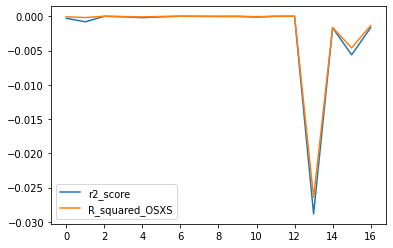

In [30]:
plt.plot(r2_scores)
plt.plot(R_squared_OSXS_s)
plt.legend(["r2_score", "R_squared_OSXS"])

### Ridge

In [139]:
ridge_reg = linear_model.Ridge()
ridge_reg.fit(X_train[used_characteristics], y_train)

/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.32134e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge()

In [140]:
y_pred = ridge_reg.predict(X_test[used_characteristics])

In [141]:
mean_squared_error(y_test, y_pred)

184.8728802035188

In [142]:
r2_score(y_test, y_pred)

-0.055462374065295306

In [143]:
R_squared_OSXS(y_test, y_pred)

-0.04456050633025699

In [176]:
import joblib
joblib.dump(ridge_reg, "ridge_reg.pkl")

['ridge_reg.pkl']

In [177]:
tmp = joblib.load("ridge_reg.pkl")


In [172]:
y_pred = tmp.predict(X_test[used_characteristics])

In [173]:
mean_squared_error(y_test, y_pred)

168.56600934104534

In [174]:
r2_score(y_test, y_pred)

-0.011083725569350333

In [175]:
R_squared_OSXS(y_test, y_pred)

-0.00041120131518823655

Ridge()

### Lasso

In [144]:
lasso_reg = linear_model.Lasso()
lasso_reg.fit(X_train[used_characteristics], y_train)

Lasso()

In [145]:
y_pred = lasso_reg.predict(X_test[used_characteristics])

In [146]:
mean_squared_error(y_test, y_pred)

175.32213312243528

In [147]:
r2_score(y_test, y_pred)

-0.0009359655558347502

In [148]:
R_squared_OSXS(y_test, y_pred)

-0.0006562900533244598

In [224]:
# CW test

In [225]:
X_test.optionid

490631    20832089
490632    21386851
490633    20387393
490634    54376425
490635    21340061
            ...   
567968    21201673
567969    21259046
567970    21224605
567971    21233682
567972    21247326
Name: optionid, Length: 77333, dtype: int64

In [226]:
true_pred_return = pd.DataFrame(
    {
        "optionid": X_test.optionid,
        "time": X_test.date_x,
        "true_return": y_test,
        "pred_return": y_pred
    }
)

In [227]:
CW_test(true_pred_return)

-0.007289892035047285

In [228]:
# DW test

In [229]:
d = 1 / true_pred_1vs2_return.shape[0] * true_pred_1vs2_return.groupby(["optionid", "time"]).apply(
    lambda group:
    sum(
        np.power(group["true_return"] - group["pred_return1"], 2)
    - np.power(group["true_return"] - group["pred_return2"], 2)
    )
)

NameError: name 'true_pred_1vs2_return' is not defined

In [230]:
np.mean(d) / np.std(d)

NameError: name 'd' is not defined

In [136]:
np.mean(c)

-2.781837086300935e-06

### ElasticNet

combines L1 and L2 punishment term

In [78]:
from sklearn.linear_model import ElasticNet

In [85]:
elastic_reg = ElasticNet(alpha=1)
elastic_reg.fit(X_train[used_characteristics], y_train)

ElasticNet(alpha=1)

In [86]:
elastic_reg.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [87]:
y_pred = elastic_reg.predict(X_test[used_characteristics])

In [88]:
mean_squared_error(y_test, y_pred)

175.33899943963218

In [89]:
r2_score(y_test, y_pred)

-0.0010322574682601893

In [90]:
R_squared_OSXS(y_test, y_pred)

-0.0007141331884756852

## Emsemble models

In [91]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
# suppress the warning of 
#   "A value is trying to be set on a copy of a slice from a DataFrame. 
#   Try using .loc[row_indexer,col_indexer] = value instead"
pd.options.mode.chained_assignment = None 

mean_squared_errors = []
r2_scores = []
R_squared_OSXS_s = []

for year in range(1996, 2020-7):
    training_data, validation_data, test_data = train_validation_test_split(option_with_feature, year)
    
    used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol', 'cp_flag_encoded']

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(training_data[used_characteristics])
    training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
    validation_data.loc[:, used_characteristics] = imp.transform(validation_data[used_characteristics])
    test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

    X_train = training_data[used_characteristics + ["date_x", "optionid"] ]
    y_train = training_data['option_ret']
    
    X_val = validation_data[used_characteristics + ["date_x", "optionid"] ]
    y_val = validation_data['option_ret']

    X_test = test_data[used_characteristics + ["date_x", "optionid"]]
    y_test = test_data['option_ret']
    

    # tuning hyperparameter on validation set
    # it costs a long time, so we just select an empirical result later instead of 
    # # running it every time
    # best_alpha = 0.1
    # best_r2_score = None
    # for alpha in [0.01, 0.1, 1]:
    #     reg = linear_model.Lasso(random_state=0, alpha=best_alpha)
    #     reg.fit(X_train[used_characteristics], y_train)
    #     y_pred = reg.predict(X_val[used_characteristics])
    #     r2_score_ = r2_score(y_val, y_pred)
    #     if best_r2_score is None or r2_score_ > best_r2_score:
    #         best_alpha = alpha 
    #         best_r2_score = r2_score_
    # print(f"best_alpha: {best_alpha}")
    
    # regression    
    best_alpha = 0.1 # empirically result from validation
    reg = GradientBoostingRegressor(
        n_estimators=100, random_state=0,
        loss='huber',
        verbose=0
    )
    reg.fit(X_train[used_characteristics], y_train)
    y_pred = reg.predict(X_test[used_characteristics])
    mean_squared_errors.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    R_squared_OSXS_s.append(R_squared_OSXS(y_test, y_pred))
    print(year, mean_squared_errors[-1], r2_scores[-1], R_squared_OSXS_s[-1])
    

1996 166.72515602566457 -4.2016534308908504e-05 -4.1556473954873496e-05
1997 9.508692113278395 -0.00032378848358183276 -0.00027012746187926595
1998 237.79133846533384 -0.00022642253960114544 -0.00016188164709585173
1999 108.35106744124403 -0.00011214897912159572 -0.00011133644794059094
2000 198.3808270540166 -0.0003826959794164253 -0.00028742152246774566
2001 159.12370164601313 6.157965301656354e-05 8.08929580028428e-05
2002 54.272135730288674 -0.0001695601997477869 -0.0001414390965177592
2003 2170.2522050606913 -1.1663807506279156e-05 -8.844989591860752e-06
2004 180.87199264407715 -0.00012506834086023488 -9.162845571530909e-05
2005 8000.543689377516 -4.1908794557343754e-05 -1.565627512500889e-05
2006 468.9234142336376 -9.705525508518775e-05 -3.965840226438644e-05
2007 980.2246825433659 -5.1316761299435854e-05 -4.604101082916756e-05


KeyboardInterrupt: 

In [29]:
reg.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': 0,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

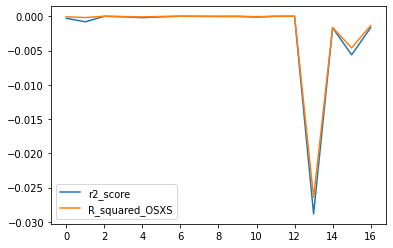

In [30]:
plt.plot(r2_scores)
plt.plot(R_squared_OSXS_s)
plt.legend(["r2_score", "R_squared_OSXS"])

### GBR

In [ ]:
gbr_reg = GradientBoostingRegressor(
    n_estimators=100, random_state=0,
    loss='huber',
    verbose=1
).fit(X_train[used_characteristics], y_train)

      Iter       Train Loss   Remaining Time 
         1           0.3940           16.10m
         2           0.3922           15.76m
         3           0.3914           15.52m
         4           0.3897           15.53m
         5           0.3883           15.41m
         6           0.3869           15.29m
         7           0.3856           15.21m
         8           0.3841           15.13m
         9           0.3830           15.17m
        10           0.3814           15.01m


In [93]:
y_pred = gbr_reg.predict(X_test[used_characteristics])

In [94]:
mean_squared_error(y_test, y_pred)

175.17011075827133

In [95]:
r2_score(y_test, y_pred)

-6.805088271000237e-05

In [96]:
R_squared_OSXS(y_test, y_pred)

-6.771774032054978e-05

<AxesSubplot:>

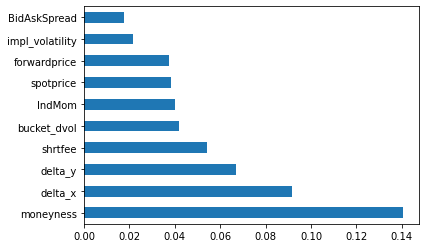

In [97]:
feat_importances = pd.Series(gbr_reg.feature_importances_, index=used_characteristics)
feat_importances.nlargest(10).plot(kind='barh')

In [250]:
X_test.sample()

,volume,ReturnSkew,MaxRet,delta,PriceDelaySlope,strike_price,IdioVol3F,ReturnSkew3F,ir_rate,mid_price,...,PriceDelayRsq,IdioVolAHT,adj_spot,vega,gamma,best_offer,DolVol,cp_flag_encoded,date_x,optionid
530009,50.0,-0.691725,-0.056886,0.612642,-0.71292,35.0,-0.020205,-0.846054,0.011254,2.3,...,0.022542,-0.023794,17.97,4.885894,0.085466,2.35,-9.32033,1.0,2003-06-30,21074852


### RF

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=3, random_state=0, 
    verbose=1)
rf_reg.fit(X_train[used_characteristics], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 27.0min finished


RandomForestRegressor(max_depth=3, n_estimators=200, random_state=0, verbose=1)

In [99]:
y_pred = rf_reg.predict(X_test[used_characteristics])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.2s finished


In [100]:
mean_squared_error(y_test, y_pred)

195.36592262704895

In [101]:
r2_score(y_test, y_pred)

-0.11536846443028015

In [102]:
R_squared_OSXS(y_test, y_pred)

-0.11515996526410688

<AxesSubplot:>

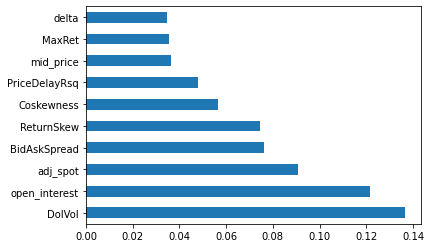

In [265]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=used_characteristics)
feat_importances.nlargest(10).plot(kind='barh')

### XGBOOST

In [139]:
training_data, validation_data, test_data = train_validation_test_split(option_with_feature, year=1996)
used_characteristics = ['volume', 'ReturnSkew', 'MaxRet', 'delta', 'PriceDelaySlope', 'strike_price', 
                        'IdioVol3F', 'ReturnSkew3F', 'ir_rate', 'mid_price', 'forwardprice', 
                        'zerotradeAlt1', 'theta', 'cfadj', 'zerotrade', 'best_bid', 'spotprice', 'VolMkt', 
                        'IdioRisk', 'days_to_exp', 'PriceDelayTstat', 'High52', 'Coskewness', 'BidAskSpread', 
                        'Beta', 'days_no_trading', 'open_interest', 'impl_volatility', 'PriceDelayRsq', 'IdioVolAHT', 
                        'adj_spot', 'vega', 'gamma', 'best_offer', 'DolVol', 'cp_flag_encoded']

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(training_data[used_characteristics])
training_data.loc[:, used_characteristics] = imp.transform(training_data[used_characteristics])
validation_data.loc[:, used_characteristics] = imp.transform(validation_data[used_characteristics])
test_data.loc[:, used_characteristics] = imp.transform(test_data[used_characteristics])

X_train = training_data[used_characteristics + ["date_x", "optionid"] ]
y_train = training_data['option_ret']

X_val = validation_data[used_characteristics + ["date_x", "optionid"] ]
y_val = validation_data['option_ret']

X_test = test_data[used_characteristics + ["date_x", "optionid"]]
y_test = test_data['option_ret']

In [162]:
import xgboost
# reg = xgboost.XGBRegressor(n_estimators=1000, max_depth=3)
reg = xgboost.XGBRegressor(
    n_estimators=4096,
    max_depth=3,
    gamma=1, 
    verbosity=1)

In [163]:
reg.fit(X_train[used_characteristics], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4096,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [161]:
reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 2}

In [151]:
?xgboost.XGBRegressor

Init signature:
xgboost.XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Va

In [164]:
y_pred = reg.predict(X_test[used_characteristics])

In [165]:
mean_squared_error(y_test, y_pred)

717.4352852475813

In [166]:
r2_score(y_test, y_pred)

-3.303282398976531

In [167]:
R_squared_OSXS(y_test, y_pred)

-3.302895635378647

<AxesSubplot:>

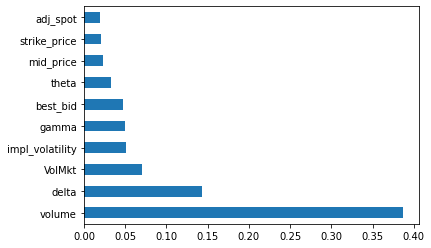

In [127]:
feat_importances = pd.Series(reg.feature_importances_, index=used_characteristics)
feat_importances.nlargest(10).plot(kind='barh')

### FNN
One epoch training on my macbook pro costs 12 hours. 
We think we don't have enough computation power for this.

In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

In [47]:
torch.tensor(option_with_feature[used_characteristics].iloc[2])

tensor([ 4.0000e+00,  1.2630e+00, -1.0909e-02,  8.3321e-01, -2.1056e-01,
         6.5000e+01, -7.8028e-03,  5.4315e-01,  5.3274e-02,  6.1250e+00,
         7.0169e+01,  5.6492e-08, -5.5153e+00,  1.0000e+00,  6.1690e-08,
         5.8750e+00,  7.0375e+01, -3.1556e-02, -1.0260e-02,  1.0800e+02,
         1.2058e+00,  9.7574e-01,  1.1993e-01,  2.0131e-03,  1.7790e-03,
         0.0000e+00,  4.2000e+02,  1.6730e-01,  1.1355e-01, -8.9034e-03,
         3.5188e+01,  9.0202e+00,  3.9200e-02,  6.3750e+00, -7.0437e+00,
         1.0000e+00], dtype=torch.float64)

In [88]:
class CustomDataset(Dataset):
    def __init__(self, dataset, used_characteristics, pred):
        self.dataset = dataset
        self.used_characteristics = used_characteristics
        self.pred = pred 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = torch.tensor(self.dataset[self.used_characteristics].iloc[idx].astype(np.float32))
        y = self.dataset[self.pred].iloc[idx].astype(np.float32)
        return x, y 

In [89]:
training_data_torch = CustomDataset(training_data, used_characteristics, "option_ret")
test_data_torch = CustomDataset(test_data, used_characteristics, "option_ret")

In [90]:
train_dataloader = DataLoader(training_data_torch, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data_torch, batch_size=64, shuffle=True)
X, Y = next(iter(train_dataloader))

In [84]:
type(X[0][0]), type(Y[0])

(torch.Tensor, torch.Tensor)

In [87]:
Y

tensor([ 8.2766e-03,  4.7117e-02, -1.9022e-02, -5.9921e-02,  5.6904e-02,
         2.6020e-01,  5.1417e-02, -2.5680e-02, -1.5497e-01, -2.5031e-02,
         1.7222e-03, -3.0399e-02,  9.1998e-03, -3.0525e-02, -1.3115e-01,
        -9.3410e-02,  2.3932e-02,  1.1766e-02, -2.3166e-02, -7.6649e-02,
         2.0566e-02, -7.7296e-02, -6.4469e-02,  9.9131e-03,  4.4708e-02,
        -1.2763e-02,  1.0602e-02,  2.2166e-04,  8.7494e-03,  9.8529e-02,
         1.2360e-02,  2.7572e-02,  2.7231e-02, -6.1731e-02, -3.1454e-02,
        -2.8895e-02,  4.9418e-03, -2.4311e-02,  6.1080e-02, -1.1035e-04,
         1.6525e-01,  2.9687e-01, -1.5116e-01, -1.0997e-02, -6.2082e-01,
        -2.0579e-02, -6.0351e-02,  1.6415e-02, -7.4811e-02,  3.5579e-02,
         2.4599e-03, -2.2690e-02, -2.1019e-02, -4.3125e-02, -3.8773e-02,
         1.2967e-01, -3.0011e-02, -2.9186e-02, -5.6971e-03, -2.6072e-02,
        -8.2621e-03, -8.6199e-01, -2.8827e-02, -5.3083e-02],
       dtype=torch.float64)

In [104]:
class NeuralNetwork(nn.Module):
    def __init__(self, n):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, n//2),
            nn.ReLU(),
            # nn.Linear(n//2, n//4),
            # nn.ReLU(),
            # nn.Linear(n//4, 1),
            nn.Linear(n//2, 1)
        )

    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [105]:
train_dataloader = DataLoader(training_data_torch, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data_torch, batch_size=256, shuffle=True)

net = NeuralNetwork(len(used_characteristics))
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, Y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.reshape(Y.shape)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

  2%|█▊                                                                            | 61/2687 [32:54<23:36:57, 32.38s/it]


KeyboardInterrupt: 

torch.Size([64])

In [35]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

TypeError: conv2d() received an invalid combination of arguments - got (method, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## Backtesting

Since the $R^2$ is not very inspiring (in finance, the data is so noisy to get a good $R^2$ score), 
we want to do a backtesting based on our trained ML model. Using the so called long-short portfolio trading strategy. 


The trading strategy is defined as follows: 
1. On current month, predict next month's option return
2. Rank the option return 
3. Long the top 10, short the tail 10 (long/short the corresponding delta hedging portfolio)


In [ ]:
import matplotlib.py

In [115]:
def backtesting(test_data, regressor):
    dates = sorted(list(set(test_data.date)))
    hedge_from_gains = []
    for i in range(len(dates)):
        df = test_data[test_data.date == dates[i]]
        df = pd.DataFrame(
            {
                "secid": df.secid_x,
                "adj_spot": df.adj_spot,
                "strike_price": df.strike_price,
                "delta": df.delta_x,
                "mid_price": df.mid_price,
                "option_ret_real": df.option_ret,
                "option_ret_pred": regressor.predict(df[used_characteristics])
            }
        )
        df["hedge_cost"] = df["mid_price"] - df["adj_spot"] * df["delta"]
        df["hedge_gain"] = abs(df["hedge_cost"]) * df["option_ret_real"]
        
        long_portfolio = df.sort_values(by="option_ret_pred").head(10)
        short_portfolio = df.sort_values(by="option_ret_pred").tail(10)
        short_portfolio.hedge_cost = - short_portfolio.hedge_cost
        hedge_from_gain = (sum(long_portfolio["hedge_cost"]) + sum(short_portfolio["hedge_cost"]) 
            + sum(long_portfolio["hedge_gain"]) + sum(short_portfolio["hedge_gain"]))
        hedge_from_gains.append(hedge_from_gain)
    return dates, hedge_from_gains
    

In [116]:
test_data.columns

Index(['Unnamed: 0', 'secid_x', 'permno', 'date', 'exdate_x', 'optionid',
       'bucket_class', 'C', 'P', 'expiration_month',
       ...
       'theta_y', 'cfadj', 'days_no_trading', 'days_to_exp', 'forwardprice',
       'spotprice', 'adj_spot', 'ir_rate', 'mid_price', 'option_ret'],
      dtype='object', length=277)

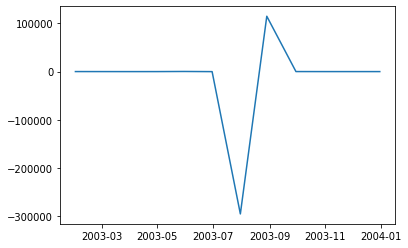

In [149]:
dates, hedge_from_gains = backtesting(test_data, lasso_reg)
plt.plot(dates, hedge_from_gains)

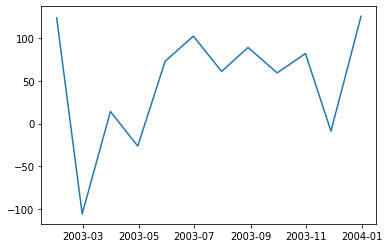

In [150]:
dates, hedge_from_gains = backtesting(test_data, ridge_reg)
plt.plot(dates, hedge_from_gains)

In [151]:
dates, hedge_from_gains = backtesting(test_data, gbr_reg)
plt.plot(dates, hedge_from_gains)

/Users/zhangjin/anaconda3/envs/aqf/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- AOP
- AccrualsBM
- Activism1
- Activism2
- AdExp
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 194 features, but GradientBoostingRegressor is expecting 262 features as input.

In [75]:
import matplotlib.pyplot as plt

In [37]:
option_with_feature.columns

Index(['Unnamed: 0', 'secid', 'date_x', 'exdate', 'cp_flag', 'strike_price',
       'best_bid', 'best_offer', 'volume', 'open_interest', 'impl_volatility',
       'delta', 'gamma', 'vega', 'theta', 'optionid', 'cfadj',
       'days_no_trading', 'days_to_exp', 'forwardprice', 'spotprice',
       'adj_spot', 'ir_rate', 'mid_price', 'option_ret', 'sdate', 'edate',
       'permno', 'date2', 'yyyymm', 'Beta', 'BidAskSpread', 'Coskewness',
       'DolVol', 'High52', 'IdioRisk', 'IdioVol3F', 'IdioVolAHT', 'MaxRet',
       'PriceDelayRsq', 'PriceDelaySlope', 'PriceDelayTstat', 'ReturnSkew',
       'ReturnSkew3F', 'VolMkt', 'zerotrade', 'zerotradeAlt1', 'date_y',
       'cp_flag_encoded'],
      dtype='object')

In [38]:
option_with_feature.sort_values(by="secid")

,Unnamed: 0,secid,date_x,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,ReturnSkew,ReturnSkew3F,VolMkt,zerotrade,zerotradeAlt1,date_y,cp_flag_encoded
0,0,5015,1996-01-31,1996-07-20 00:00:00,C,20.0,4.6250,5.0000,15,25,...,0.041281,0.389311,1.212702,1.425051,1.314407,-0.083688,2.212753e-08,2.905242e-08,1996-01-01,1
2104,2104,5015,1996-01-31,1996-07-20 00:00:00,C,27.5,0.9375,1.1875,1,55,...,0.041281,0.389311,1.212702,1.425051,1.314407,-0.083688,2.212753e-08,2.905242e-08,1996-01-01,1
124598,124598,5015,1998-07-31,1998-10-17 00:00:00,P,70.0,5.8750,6.2500,5,32,...,0.062768,-0.221246,-1.163268,-0.087869,0.251508,-0.129950,1.494627e-08,1.855388e-08,1998-07-01,0
124597,124597,5015,1998-07-31,1999-01-16 00:00:00,C,70.0,4.3750,4.7500,10,35,...,0.062768,-0.221246,-1.163268,-0.087869,0.251508,-0.129950,1.494627e-08,1.855388e-08,1998-07-01,1
41988,41988,5015,1997-01-31,1997-07-19 00:00:00,P,35.0,1.3125,1.5625,10,55,...,0.381327,-1.615642,1.212702,0.190639,-1.284276,-0.081350,2.433947e-08,1.740106e-08,1997-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168133,3168133,213212,2019-12-31,2020-08-21 00:00:00,P,17.5,0.7500,0.9000,54,33,...,0.107279,0.786024,1.873614,-0.062024,0.379443,-0.427328,8.234986e-09,1.198200e-08,2019-12-01,0
2914495,2914495,213212,2018-12-31,2019-08-16 00:00:00,C,17.5,0.4000,1.0000,28,1,...,0.055853,-0.669433,3.417680,-0.013643,0.527326,-1.600722,5.873811e-09,6.332559e-09,2018-12-01,1
2941619,2941619,213212,2019-01-31,2019-05-17 00:00:00,C,17.5,0.6500,2.4000,15,70,...,0.055853,-0.669433,3.417680,-0.179418,-0.908827,-1.341789,6.179499e-09,6.427636e-09,2019-01-01,1
3052187,3052187,213212,2019-06-28,2020-02-21 00:00:00,C,20.0,0.0500,1.5500,120,31,...,0.055853,-0.669433,3.417680,-0.194380,0.314063,-1.230118,6.836241e-09,4.644217e-09,2019-06-01,1


## DW test

In [158]:
true_pred_1vs2_return = pd.DataFrame(
    {
        "optionid": X_test.optionid,
        "time": X_test.date_x,
        "true_return": y_test,
        "pred_return1": regressor.predict(X_test[used_characteristics]),
        "pred_return2": est.predict(X_test[used_characteristics])
    }
)

In [ ]:
DW_test(true_pred_1vs2_return)